In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import rioxarray
import urbanpy as up
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from geocube.api.core import make_geocube

In [2]:
tqdm.pandas()

In [3]:
# Read the grid data
gdf_celdas = gpd.read_parquet("outputs/celdas.parquet")

In [4]:
# Download the boundaries of Peru
peru = up.download.nominatim_osm("Peru", 0, email="claudio@autodash.org")
peru.to_parquet("outputs/peru_polygon.parquet")

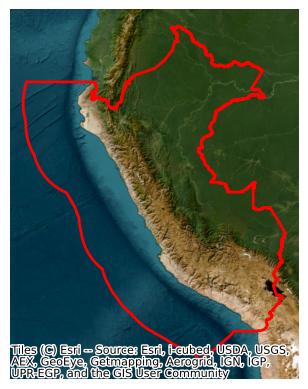

In [5]:
# Check the boundaries with a plot
fig, ax = plt.subplots()

peru.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=peru.crs)

ax.set_axis_off()

plt.show()

In [6]:
# Filter the grid data to only include cells that intersect with Peru
celdas_peru = gdf_celdas[gdf_celdas.intersects(peru.geometry[0])]
celdas_peru.shape

(9749, 14)

In [7]:
# Read one tiff file with the population data (WorldPop)
xds = rioxarray.open_rasterio(
    "/Users/claudio/Documents/amazonia-bid/inputs/WorldPop/per/per_f_5_2020.tif",
    masked=True,
)

In [8]:
# Check an observation
obs = celdas_peru.iloc[0]
obs

cell_id                                                   00001
smod                                              urban_cluster
pop_1975                                             773.876615
pop_1980                                            1497.169295
pop_1985                                            2214.783282
pop_1990                                            2936.382639
pop_1995                                             3759.68052
pop_2000                                            4684.930881
pop_2005                                            5639.160211
pop_2010                                            6578.468722
pop_2015                                             7511.42015
pop_2020                                            8490.616181
polygon_id                                            02559-1-1
geometry      POLYGON ((-79.52571590152914 -5.57578382592957...
Name: 0, dtype: object

In [9]:
# Find all the cells that are part of the same polygon
polygon_example = celdas_peru[celdas_peru["polygon_id"] == obs["polygon_id"]]

In [10]:
# Calculate the total population in the polygon
polygon_example["pop_2020"].sum()

np.float64(53223.145702963695)

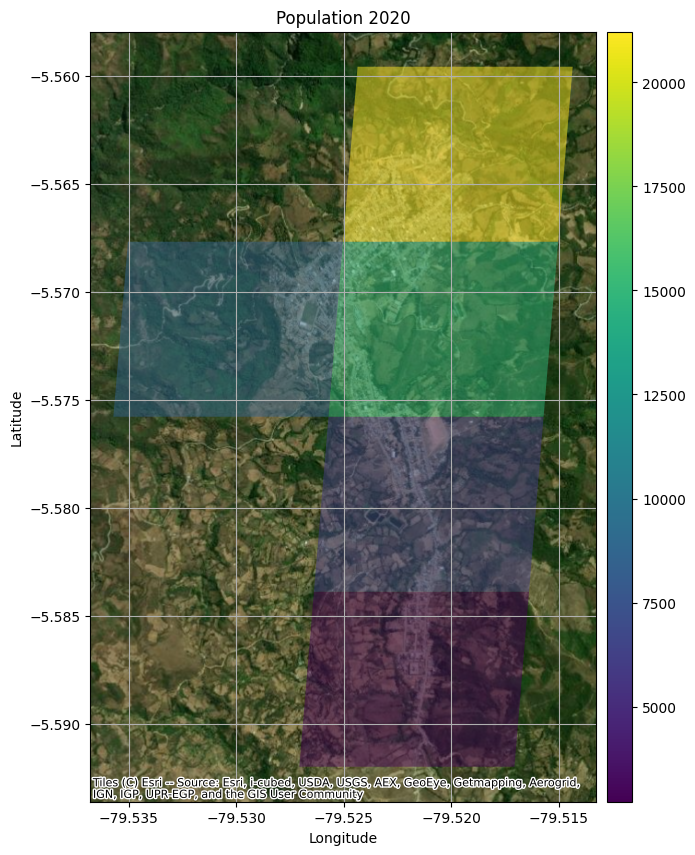

In [11]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_visible(True)

# Plot the polygon with the population data
polygon_example.plot(ax=ax, column="pop_2020", alpha=0.5, legend=True, cax=cax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Population 2020")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [12]:
# Check crs of the grid and the raster
assert celdas_peru.crs.to_string() == xds.rio.crs.to_string(), "CRS mismatch"

In [13]:
# Clip the raster with the polygon
clipped = xds.rio.clip(
    polygon_example.geometry.values,
    polygon_example.crs,
    from_disk=True,
)
clipped

<xarray.DataArray (band: 1, y: 40, x: 27)> Size: 9kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.02260291,
         0.0215873 ,        nan],
        [       nan,        nan,        nan, ..., 0.02398969,
         0.02383111,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * x            (x) float64 216B -79.54 -79.53 -79.53 ... -79.52 -79.51 -79.51
  * y            (y) float64 320B -5.559 -5.56 -5.561 ... -5.59 -5.591 -5.592
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [49]:
# We have to rasterize the cell_id to be able to calculate the total population in each cell

# Convert the cell_id to integer
polygon_example.loc[:, "cell_id"] = polygon_example.cell_id.astype(int)

# Create a geocube with the cell_id as the data variable
mask = make_geocube(
    polygon_example,
    measurements=["cell_id"],
    like=clipped,
    fill=0,
)
mask

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 12815, x: 11420)
Coordinates:
  * y            (y) float64 103kB -9.698 -9.699 -9.7 ... -20.37 -20.38 -20.38
  * x            (x) float64 91kB -69.58 -69.58 -69.58 ... -60.07 -60.07 -60.07
    spatial_ref  int64 8B 0
Data variables:
    cell_id      (y, x) int64 1GB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [15]:
# Since the mask and the clipped raster are the same size,
# we can add a new dimension to the mask for the population using the clipped raster

# Remove the 'flat' dimension (worldpop data only has one band)
clipped_sq = clipped.squeeze()
# Add the population data to the mask
mask["pop"] = (
    clipped_sq.dims,
    clipped_sq.values,
    clipped_sq.attrs,
    clipped_sq.encoding,
)
mask

<xarray.Dataset> Size: 18kB
Dimensions:      (y: 40, x: 27)
Coordinates:
  * y            (y) float64 320B -5.559 -5.56 -5.561 ... -5.59 -5.591 -5.592
  * x            (x) float64 216B -79.54 -79.53 -79.53 ... -79.52 -79.51 -79.51
    spatial_ref  int64 8B 0
Data variables:
    cell_id      (y, x) int64 9kB 0 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 0 0 0 0
    pop          (y, x) float64 9kB nan nan nan nan nan ... nan nan nan nan

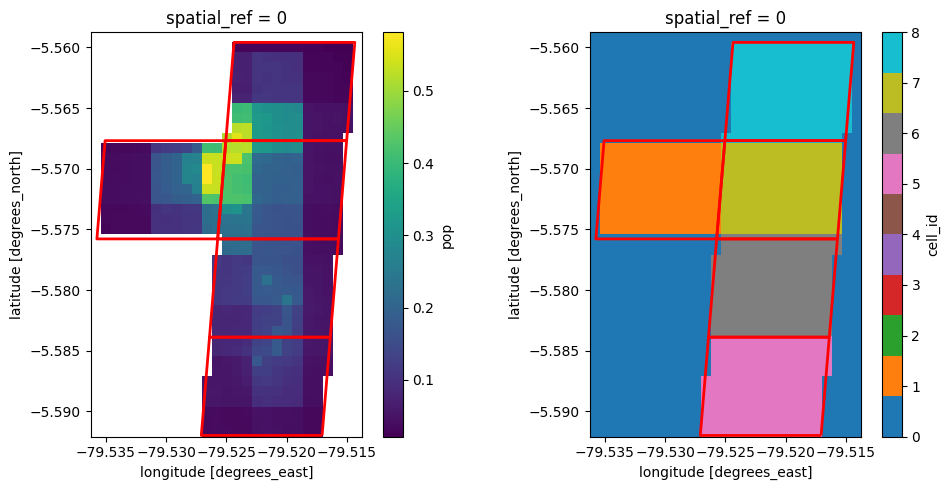

In [16]:
# Let's visualize the clipped population data and the rasterized cell_id

# Create a figure and axis
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

mask.pop.plot.imshow(ax=axes[0], cmap="viridis")
polygon_example.plot(ax=axes[0], edgecolor="red", facecolor="none", linewidth=2)

mask.cell_id.plot.imshow(ax=axes[1], cmap="tab10")
polygon_example.plot(ax=axes[1], edgecolor="red", facecolor="none", linewidth=2)

plt.tight_layout()
plt.show()

In [17]:
# Now we can calculate the total population in each cell and add it back to the geodataframe
agg_pop = mask.drop("spatial_ref").groupby(mask.cell_id).sum().to_dataframe()
agg_pop

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_47175/1937882669.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  agg_pop = mask.drop("spatial_ref").groupby(mask.cell_id).sum().to_dataframe()
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cell_id because variable cell_id is not a coordinate. To create an index for cell_id, please first call `.set_coords('cell_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


,pop
cell_id,
0,0.000000
1,16.591460
5,8.442062
6,14.419483
7,20.974643
8,15.739156


In [18]:
merged_data = pd.merge(
    polygon_example,
    agg_pop,
    how="left",
    left_on="cell_id",
    right_index=True,
    suffixes=("", "_agg"),
)
merged_data

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015,pop_2020,polygon_id,geometry,pop
0,1,urban_cluster,773.876615,1497.169295,2214.783282,2936.382639,3759.680520,4684.930881,5639.160211,6578.468722,7511.420150,8490.616181,02559-1-1,"POLYGON ((-79.52572 -5.57578, -79.52504 -5.567...",16.591460
4,5,urban_cluster,176.856075,356.591034,548.408754,750.600224,1013.627816,1348.696712,1691.794096,2031.490143,2367.579627,2713.444995,02559-1-1,"POLYGON ((-79.51707 -5.59199, -79.51639 -5.583...",8.442062
5,6,urban_cluster,485.121460,988.300077,1523.640198,2095.555934,2728.184624,3420.226932,4098.117928,4733.791179,5341.067337,5969.348827,02559-1-1,"POLYGON ((-79.51639 -5.58389, -79.51571 -5.575...",14.419483
6,7,urban_cluster,1128.496620,2238.039294,3394.996752,4595.326297,6052.609456,7792.777291,9552.957572,11255.133058,12946.622823,14832.131212,02559-1-1,"POLYGON ((-79.51571 -5.57578, -79.51503 -5.567...",20.974643
7,8,urban_cluster,1071.719331,2320.113382,3737.758579,5321.671362,7276.881465,9616.562252,12279.881839,15121.957494,18103.295487,21217.604488,02559-1-1,"POLYGON ((-79.51503 -5.56768, -79.51436 -5.559...",15.739156


In [19]:
# Check the merged_data has the same number of rows as the original polygon_example
assert merged_data.shape[0] == polygon_example.shape[0], "Number of rows mismatch"

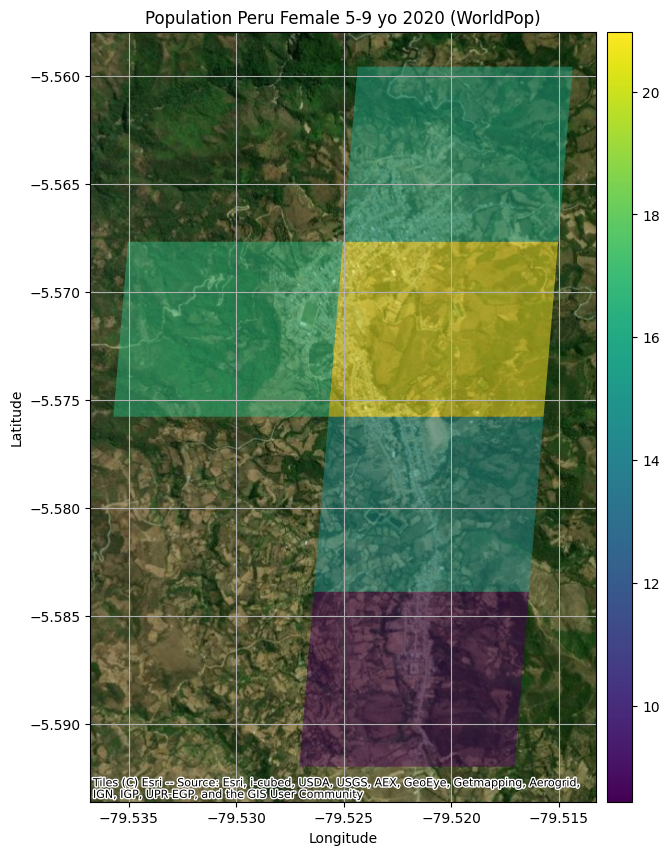

In [20]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_visible(True)

# Plot the polygon with the population data
merged_data.plot(ax=ax, column="pop", alpha=0.5, legend=True, cax=cax)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Population Peru Female 5-9 yo 2020 (WorldPop)")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [21]:
# Awesome! Now we will apply the same process for the other population ranges and countries